<a href="https://colab.research.google.com/github/raeubaen/giagu/blob/master/NB_GD_LC1_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tecniche di Gradient Descent 

## Informazioni:

scopo: fare pratica con l'uso della tecnica di discesa lungo il gradiente e delle tecniche associate (momentum, ADAM, RMSProp, ...) per lo studio dei minimi di funzioni bidimensionali.

**Prima parte: visualizzazione grafica delle funzioni**

In [1]:
# setup delle funzioni di visualizzazione di base usate successivamente

# configura matplotlib in modo che l'output sia in linea con il codice della cella del notebook che lo ha
# prodotto e sia salvato con il notebook stesso
%matplotlib inline

# importa le librerie necessarie
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# 3D plots
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm
from collections import OrderedDict as OrD

# funzioni per plottare
def plot_surface(x, y, z,
    azim=-60, elev=40, dist=10, cmap="RdYlBu_r",
    xlimL=1, xlimH=1, ylimL=1, ylimH=1, zlimL=2, zlimH=2,):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    plot_args = {
        "rstride": 1,
        "cstride": 1,
        "cmap": cmap,
        "linewidth": 20,
        "antialiased": True,
        "vmin": -2,
        "vmax": 2,
    }
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim=azim, elev=elev)
    ax.dist = dist
    ax.set_xlim(-xlimL, xlimH)
    ax.set_ylim(-ylimL, ylimH)
    ax.set_zlim(-zlimL, zlimH)

    plt.xticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    plt.yticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    ax.set_zticks([-2, -1, 0, 1, 2])
    ax.set_zticklabels(["-2", "-1", "0", "1", "2"])

    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)

    return fig, ax


def overlay_trajectory_quiver(ax, obj_func, trajectory, color="k"):
    xs = trajectory[:, 0]
    ys = trajectory[:, 1]
    zs = obj_func(xs, ys)
    ax.quiver(
        xs[:-1],
        ys[:-1],
        zs[:-1],
        xs[1:] - xs[:-1],
        ys[1:] - ys[:-1],
        zs[1:] - zs[:-1],
        color=color,
        arrow_length_ratio=0.3,
    )

    return ax


def overlay_trajectory(ax, obj_func, trajectory, label, color="k"):
    xs = trajectory[:, 0]
    ys = trajectory[:, 1]
    zs = obj_func(xs, ys)
    ax.plot(xs, ys, zs, color, label=label)

    return ax


def overlay_trajectory_contour_M(ax, trajectory, label, color="k", lw=2):
    xs = trajectory[:, 0]
    ys = trajectory[:, 1]
    ax.plot(xs, ys, color, label=label, lw=lw)
    ax.plot(xs[-1], ys[-1], color + ">", markersize=14)
    return ax


def overlay_trajectory_contour(ax, trajectory, label, color="k", lw=2):
    xs = trajectory[:, 0]
    ys = trajectory[:, 1]
    ax.plot(xs, ys, color, label=label, lw=lw)
    return ax

**Funzioni da studiare**

* funzione con minimo quadratico: $$z=ax^2+by^2,$$

* fuzione con un punto di sella: $$z=ax^2-by^2,$$

* funzione convessa di Beale: $$z = (1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2$$ con minimo in $$(\hat{x},\hat{y})=(3,0.5)$$

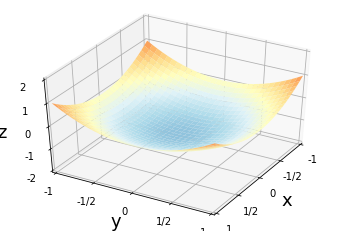

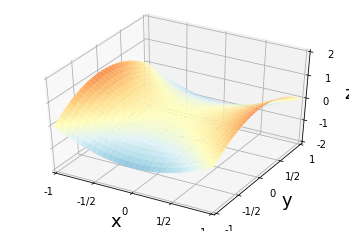

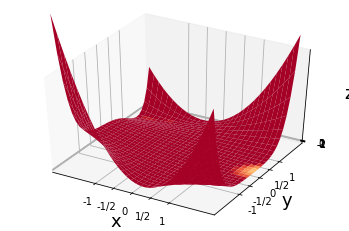

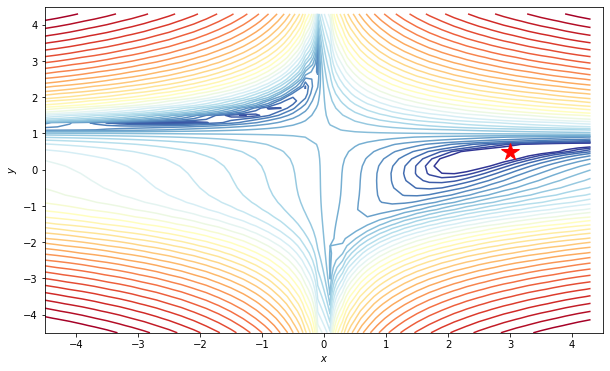

In [2]:
# funzione con minimo quadratico
def minima_surface(x, y, a=1, b=1):
    return a * x ** 2 + b * y ** 2 - 1


# gradiente analitico
def grad_minima_surface(params, a=1, b=1):
    x = params[0]
    y = params[1]
    grad_x = 2 * a * x
    grad_y = 2 * b * y
    return [grad_x, grad_y]


# funzione con punto di sella
def saddle_surface(x, y, a=1, b=1):
    return a * x ** 2 - b * y ** 2


# gradiente analitico
def grad_saddle_surface(params, a=1, b=1):
    x = params[0]
    y = params[1]
    grad_x = 2 * a * x
    grad_y = -2 * b * y
    return [grad_x, grad_y]


# funzione di Beale
def beales_function(x, y):
    z = (
        np.square(1.5 - x + x * y)
        + np.square(2.25 - x + x * y * y)
        + np.square(2.625 - x + x * y ** 3)
    )
    return z


# gradiente analitico
def grad_beales_function(params):
    x = params[0]
    y = params[1]
    grad_x = (
        2 * (1.5 - x + x * y) * (-1 + y)
        + 2 * (2.25 - x + x * y ** 2) * (-1 + y ** 2)
        + 2 * (2.625 - x + x * y ** 3) * (-1 + y ** 3)
    )
    grad_y = (
        2 * (1.5 - x + x * y) * x
        + 4 * (2.25 - x + x * y ** 2) * x * y
        + 6 * (2.625 - x + x * y ** 3) * x * y ** 2
    )
    return [grad_x, grad_y]


# contour plot della funzione di Beale
def contour_beales_function():
    # plot beales function
    x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
    fig, ax = plt.subplots(figsize=(10, 6))
    z = beales_function(x, y)
    cax = ax.contour(
        x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r"
    )
    ax.plot(3, 0.5, "r*", markersize=18)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_xlim((-4.5, 4.5))
    ax.set_ylim((-4.5, 4.5))
    return fig, ax


# plot delle superfici
plt.close()  # chiudi qualsiasi plot precedente
x, y = np.mgrid[-1:1:31j, -1:1:31j]
fig1, ax1 = plot_surface(x, y, minima_surface(x, y, 1), 30)
fig2, ax2 = plot_surface(x, y, saddle_surface(x, y))
x, y = np.mgrid[-2:2:31j, -2:2:31j]
fig3, ax3 = plot_surface(x, y, beales_function(x, y),
    xlimL=2.1, xlimH=2.1, ylimL=2.1, ylimH=2.1, zlimL=0, zlimH=300,)

# Contour plot della funzione di Bale
fig4, ax4 = contour_beales_function()
plt.show()

## Parte 2: discesa lungo il gradiente con e senza momentum

<b>simple Gradient Descent</b>

Implementazione di una semplice discesa lungo il gradiente, in cui dato un set di parametri $w$, qusti vengono aggiornati ad ogni iterazione nella direzione del gradiente locale:

$$w_{t+1}= w_t - \eta_t \nabla_w E(w),$$

in cui $E(w)$ rappresenta la funzione (energia nel linguaggio della fisica) che vogliamo minimizzare.

Il parametro $\eta_t$ (lerning rate) controlla la larghezza di ciascuno step. In generale l'algoritmo è estremamente sensibile al valore di $\eta_t$, se è troppo grande possono comparire grandi oscillazioni intorno al minimo (perdendo controllo sule strutture a piccola scala della funzione). Il problema diventa sempre più grande quanto più rumore è presente nelle stime de gradiente (come succede nel ML in cui il gradiente viene cacolato su campioni di eventi di dimensione limitata). Se $\eta_t$ è troppo piccola la porcedura di ottimizzazione diviene estremamente lenta.


<b>Gradient Descent + Momentum</b>

Aggiungere informazione su cosa è successo nelle iterazioni precedenti ("da dove proviene la palla che rotola giù dalla collina") aiuta ad evitare problemi con minimi locali sopratutto in presenza di rumore stocastico.
Questo può essere fatto aggiungendo un termine di memoria o momentum che permette sia di risucire ad uscire da minimi locali, sia di non reagire in modo esagerato ai cambiamenti presenti ad ogni nuova iterazione.
La regola di update diviene:

$$
v_{t}=\gamma v_{t-1}+\eta_{t}\nabla_w E(w_t),\\
w_{t+1}= w_t -v_{t},
$$

in cui $0\le \gamma < 1$ è un parametro detto momentum. Quando $\gamma=0$ si riottiene il GD ordinario, aumentando 
$\gamma$ aumenta il contributo di inerzia al gardiente.

In [3]:
# implementazione funzioni GD e GD+momentum
# nota viene introdotta la possibilità di aggiungere una componente rumorosa al calcolo del gradiente per simulare
# l'effetto nell'uso del ML con campioni di dimensione finita

'''
Arguments:
  defined: Dict - contains the hyperparameters values needed (with laTex keys, to copy it in the legend)
  default: Dict (if only one key) or OrderedDict - contains the default hyperparameters values
Returns a list of hyperparameters values as in 'defined',
with the same order of 'default'.
If an hyperparameter is not in 'defined', its value is taken from default.
'''
def get_par(defined, default):
    return [defined[key] if key in defined else default[key] for key in default]

# GD {}
def gd(grad, init, hyper_par, n_epochs=1000, noise_strength=0):
    default_par = {"$\eta$": 0.1}
    eta = get_par(hyper_par, default_par)

    params = np.array(init)
    param_traj = np.zeros([n_epochs + 1, 2])
    param_traj[0,] = init
    v = 0
    for j in range(n_epochs):
        noise = noise_strength * np.random.randn(params.size)
        v = eta * (np.array(grad(params)) + noise)
        params = params - v
        param_traj[j + 1,] = params
    legend = "GD " + ", ".join(f"{key}={hyper_par[key]}" for key in hyper_par)
    return (param_traj, legend)


# GD + momentum
def gd_with_mom(grad, init, hyper_par, n_epochs=5000, noise_strength=0):
    default_par = OrD([("$\eta$", 0.1), ("$\gamma$", 0.9)])
    eta, gamma = get_par(hyper_par, default_par)

    params = np.array(init)
    param_traj = np.zeros([n_epochs + 1, 2])
    param_traj[0,] = init
    v = 0
    for j in range(n_epochs):
        noise = noise_strength * np.random.randn(params.size)
        v = gamma * v + eta * (np.array(grad(params)) + noise)
        params = params - v
        param_traj[j + 1,] = params
    legend = "GD+M " + ", ".join(f"{key}={hyper_par[key]}" for key in hyper_par)
    return (param_traj, legend)


def run_and_plot(ax, gradient, init, hyper_par, 
                 marker='o', n_epochs=100, opt=gd, arrow=False, noise=0):
    param_traj, legend = opt(gradient, init, hyper_par, n_epochs=n_epochs)
    if arrow:
        overlay_trajectory_contour_M(ax, param_traj, legend, marker, lw=0.5)
    else:
        overlay_trajectory_contour(ax, param_traj, legend, marker, lw=0.5)
    return param_traj

# Applicazione di GD e GD+momentum

Applichiamo l'algoritmo alla funzione con minimo quadratico $z=ax^2+by^2-1$ con ($a=b=1$).

**Cose si vuole testare:**
* dipendenza dal learning rate: $\eta=0.1,0.5,1,1.01$;
* dipendenza dai parameri della funzione

**Da fare come esercizio:**
* cosa cambia modificando i parametri $a$ e $b$ della funzione? Superfici anisotrope presentano lo stesso comportamento?
* provare cosa cambia usando GD_momentum. Come cambia la dipendenza da $\eta$ rispetto al caso senza momentum?

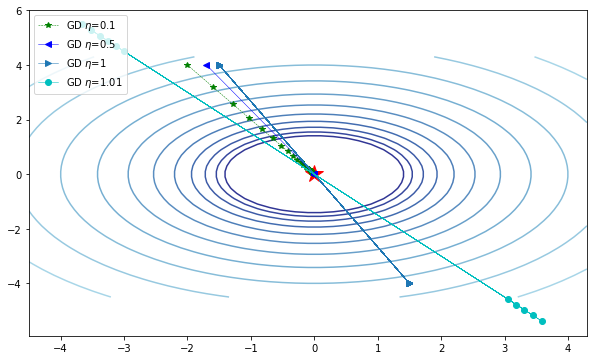

In [4]:
# studio effetto learning rate in GD
plt.close()
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))

a, b = 1.0, 1.0
z = np.abs(minima_surface(x, y, a, b))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0, 0, 'r*', markersize=18)

#run_and_plot(ax, gradient, init, hyper_par, marker='o', n_epochs=100, opt=gd, arrow=False, noise=0):

run_and_plot(ax, grad_minima_surface, [-2,   4],   {'$\eta$': 0.1}, 'g--*')
run_and_plot(ax, grad_minima_surface, [-1.7, 4],   {'$\eta$': 0.5}, 'b-<')
run_and_plot(ax, grad_minima_surface, [-1.5, 4],   {'$\eta$': 1}, '->')
run_and_plot(ax, grad_minima_surface, [-3,   4.5], {'$\eta$': 1.01}, 'c-o', n_epochs=10)

plt.legend(loc=2)
plt.show()
fig.savefig("NB_GD_plot1.pdf", bbox_inches='tight')

### Svolgimento dell'esercizio
Essendo la funzione asimmetrica compare un caso patologico, non presente in precedenza. <br>
Il gradiente è definito come $(2ax, 2by)$, per cui se scegliamo un punto di partenza $(x_0,y_0)$ tale che $(x_1,y_1) = (-x_0,y_1)$ allora non avremo convergenza su $x$, ma oscillazione. <br>
Scegliamo quindi $\eta=0.1$ (valore che in precedenza assicurava la convergenza), ma scegliamo $a = 10$, per cui: <br>
$x_1 = x_0 - 0.1 \cdot 2 \cdot 10 \cdot x_0 = - x_0$. <br>
Sull'asse $y$ si ha invece convergenza esponenziale.

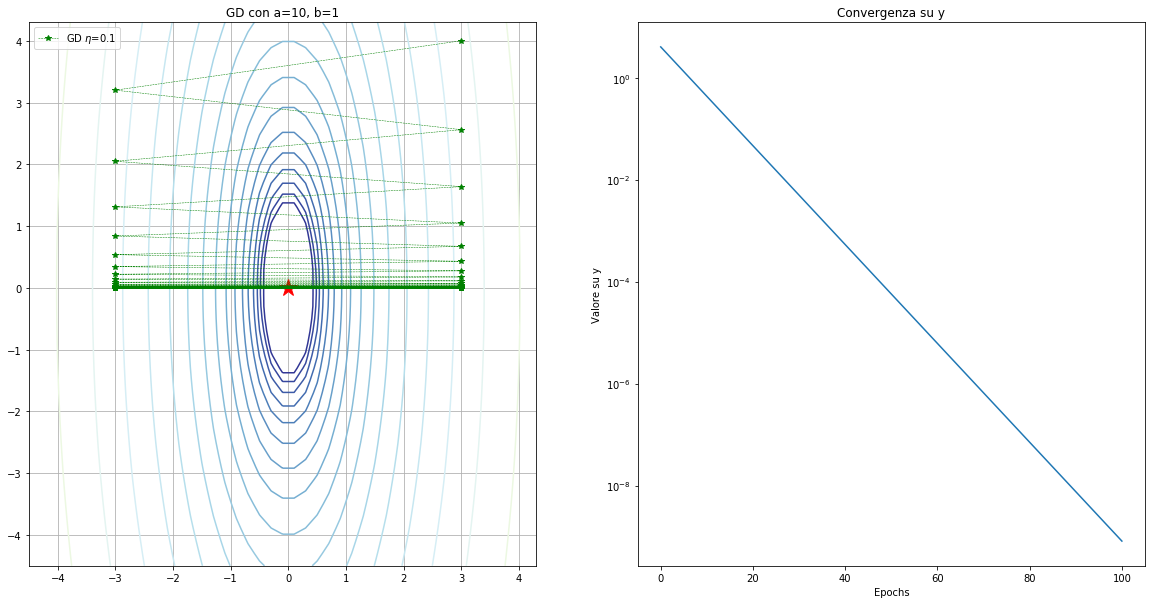

In [57]:
#plottiamo le curve di livello
plt.close()
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax = axs[0]
z = np.abs(minima_surface(x, y, a, b))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0, 0, 'r*', markersize=18)

#creiamo una funzione che restituisca la funzione gradiente, fissati a e b
def make_grad(a, b):
    def f(params):
        x = params[0]
        y = params[1]
        grad_x = 2 * a * x
        grad_y = 2 * b * y
        return [grad_x, grad_y]
    return f

init = [3, 4] #per migliore resa grafica

ptj = run_and_plot(ax, make_grad(10, 1), init,   {'$\eta$': 0.1}, 'g--*')

ax.legend(loc=2)
ax.grid()
ax.set(title = "GD con a=10, b=1")

Y = np.asarray(ptj)[:, 1]
ax1 = axs[1]
ax1.semilogy()
ax1.plot(Y)
ax1.set(ylabel="Valore su y", xlabel = "Epochs", title="Convergenza su y")

plt.show()

Nei casi non patologici, a differenza del caso simmetrico, la discesa non avviene lungo il raggio che va dal punto iniziale verso l'origine, ma lungo una traiettoria curva non oscillante, come si vede in figura, con $\eta = 0.06, a=3, b=1$.
Ciò avviene quando $a \cdot \eta < 0.5$.
Nei casi $0.5 < a \cdot \eta < 1$ la traiettoria, seppur convergente, presenta oscillazioni.

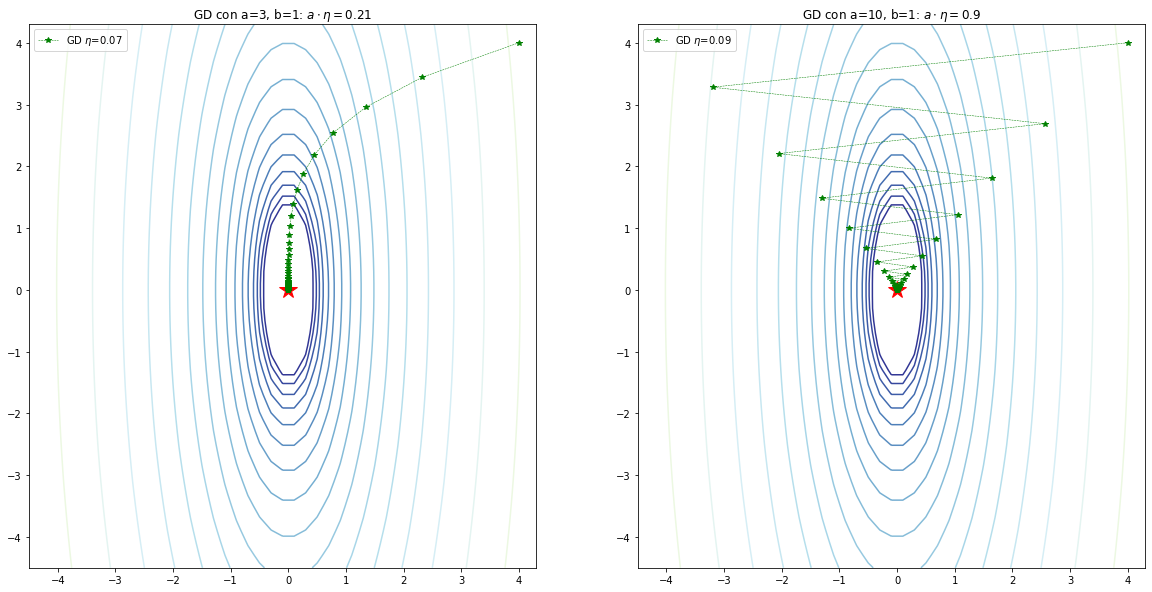

In [58]:
#plottiamo le curve di livello
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
z = np.abs(minima_surface(x, y, a, b))
for ax in axs:
    ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
    ax.plot(0, 0, 'r*', markersize=18)

ptj = run_and_plot(axs[0], make_grad(3, 1), [4,4], {'$\eta$': 0.07}, 'g--*')
ptj = run_and_plot(axs[1], make_grad(10, 1), [4,4], {'$\eta$': 0.09}, 'g--*')

axs[0].legend(loc=2)
axs[1].legend(loc=2)

axs[0].set(title="GD con a=3, b=1: $a\cdot \eta = 0.21$")
axs[1].set(title="GD con a=10, b=1: $a\cdot \eta = 0.9$")
plt.show()



## Tecniche GD con uso di learning rate adattivi: RMSProp e ADAM

Il learning rate è fissato dalla direzione più ripida del landscape della funzione da minimizzare, ma questa può cambiare a seconda del punto locale in cui ci troviamo. <br>
Per aggirare questo problema, idealmente dovremmo scegliere di dare grandi step nelle direzioni che corrispondono a zone piatte del landscape energetico e piccoli passi in direzioni ripide e strette. <br>
I cosidetti metodi del secondo ordine ottengono questo risultato calcolando o approssimando l'Hessiano e normalizzando il learning rate con la curvatura delal superficie nell'intorno del punto in cui ci si trova.  <br>
Questi metodi tuttavia sono molto costosti dal punto di vista computazionale specie per modelli con un grande numero di parametri e quindi in pratica non sono applicabili. <br>
Sono stati quindi introdotti numerosi metodi che consentono in modo computazionalemnte efficiente di adattare il learning rate seguendo il gradiente ed il momento secondo del gradiente stesso. <br>
Metodi di questo tipo includono AdaGrad, AdaDelta, RMSProp e ADAM. 

* Esempio: RMSProp (Root-Mean-Square propagation)

durante le iterazioni oltre a tenere in memoria il momento primo del gradiente attraverso una media mobile (running average), viene anche tenuta memoria del momento secondo. La regola di aggiornamento è data da:

$$
\mathbf{g}_t = \nabla_w E(\boldsymbol{w}) \\
\mathbf{s}_t =\beta \mathbf{s}_{t-1} +(1-\beta)\mathbf{g}_t^2 \nonumber \\
\boldsymbol{w}_{t+1}=\boldsymbol{w}_t + \eta_t { \mathbf{g}_t \over \sqrt{\mathbf{s}_t +\epsilon}}, \nonumber \\
$$

con $\beta$ parametro che controlla il tempo di media del momento secondo (tipicamente $\beta\sim 0.9$), e 
$\eta_t$ learning rate (tipicamente $\sim 10^{-3}$ e $\epsilon\sim 10^{-8}$ una piccola costante che serve ad evitare divergenze.

Si vede come il learning rate è ridotto nelle direzioni in cui la norma del gradiente è costantemente ampia. Ciò accelera notevolmente la convergenza consentendoci di utilizzare un tasso di apprendimento più ampio per direzioni piatte.

* Esempio: ADAM (Adaptive Moment Estimation)

Corregge le stime del primo e secondo momento per il bias dovuto al fatto che sono stime fatte con medie mobili:

$$
\mathbf{g}_t = \nabla_w E(\boldsymbol{w}) \\
\mathbf{m}_t = \beta_1 \mathbf{m}_{t-1} + (1-\beta_1) \mathbf{g}_t \nonumber \\
\mathbf{s}_t =\beta_2 \mathbf{s}_{t-1} +(1-\beta_2)\mathbf{g}_t^2 \nonumber \\
\hat{\mathbf{m}}_t={\mathbf{m}_t \over 1-\beta_1} \nonumber \\
\hat{\mathbf{s}}_t ={\mathbf{s}_t \over1-\beta_2} \nonumber \\
\boldsymbol{w}_{t+1}=\boldsymbol{w}_t + \eta_t { \hat{\mathbf{m}}_t \over \sqrt{\hat{\mathbf{s}}_t +\epsilon}}, \nonumber 
$$

con $\beta_1$ e $\beta_2$ che fissano le vite-medie del primo e secondo momento e sono tipicamente $0.9$ e $0.99$ rispettivamente. $\eta$ e $\epsilon$ sono gli stessi di RMSProp.

In [6]:
# Implementazione RMSProp e ADAM


def rms_prop(grad, init, hyper_par, n_epochs=5000, noise_strength=0):
    default_par = OrD([
        ("$\eta$", 10 ** -3), 
        ("$\beta$", 0.9), 
        ("$\epsilon$", 10 ** -8)
        ])
    eta, beta, epsilon = get_par(hyper_par, default_par)

    params = np.array(init)
    param_traj = np.zeros([n_epochs + 1, 2])
    param_traj[0,] = init
    grad_sq = 0
    for j in range(n_epochs):
        noise = noise_strength * np.random.randn(params.size)
        g = np.array(grad(params)) + noise
        grad_sq = beta * grad_sq + (1 - beta) * g * g
        v = eta * np.divide(g, np.sqrt(grad_sq + epsilon))
        params = params - v
        param_traj[j + 1,] = params

    legend = "RMSprop " + ", ".join(f"{key}={hyper_par[key]}" for key in hyper_par)
    return (param_traj, legend)


def adams(grad, init, hyper_par, n_epochs=5000, noise_strength=0):
    default_par = OrD([
            ("$\eta$", 10 ** -3),
            ("$\gamma$", 0.9),
            ("$\beta$", 0.99),
            ("$\epsilon$", 10 ** -8),
    ])
    eta, gamma, beta, epsilon = get_par(hyper_par, default_par)

    params = np.array(init)
    param_traj = np.zeros([n_epochs + 1, 2])
    param_traj[0,] = init
    v = 0
    grad_sq = 0
    for j in range(n_epochs):
        noise = noise_strength * np.random.randn(params.size)
        g = np.array(grad(params)) + noise
        v = gamma * v + (1 - gamma) * g
        grad_sq = beta * grad_sq + (1 - beta) * g * g
        v_hat = v / (1 - gamma)
        grad_sq_hat = grad_sq / (1 - beta)
        params = params - eta * np.divide(v_hat, np.sqrt(grad_sq_hat + epsilon))
        param_traj[j + 1,] = params
    legend = "ADAM " + ", ".join(f"{key}={hyper_par[key]}" for key in hyper_par)
    return (param_traj, legend)

## Applicazione di RMSProp e ADAM


Applichiamo quanto visto alla funzione di Beale: 

$$
z = f(x,y) = (1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2.
$$

con minimo globale in $(x,y)=(3,0.5)$.

**Cose si vuole testare:**

* trovare il minimo con: GD, GD+momentum, RMSProp, ADAM, parteno da condizioni iniziali diverse
* analizzare come cambiano le cose cambiando $\eta$ e il numero di iterazioni
* analizzare cosa si ottiene usando $N_{\mathrm{steps}}=10^4$ e $\eta=10^{-3}$ per ADAM/RMSProp e $\eta=10^{-6}$ per GD e GD+momentum

**Da fare come esercizio:**

* cosa succede usando $\eta=10^{-6}$ anche per ADAM/RMSProp 
* cosa succede inserendo del rumore nel gioco (ad esempio noise=10)?
* giocate con i parametri degli algoritmi ADAM e RMSProp, cosa cambia?

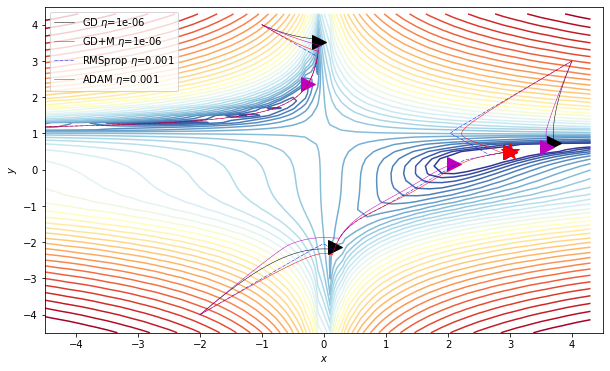

In [7]:
plt.close()

N1=10**4
lr_l=10**-3
lr_s=10**-6

init1 = np.array([4, 3])
fig1, ax1=contour_beales_function()

grad = grad_beales_function

#run_and_plot(ax, gradient, init, hyper_par, marker='o', n_epochs=100, opt=gd, arrow=False, noise=0):
run_and_plot(ax1, grad, init1, {'$\eta$': lr_s}, 'k', N1, gd, True)
run_and_plot(ax1, grad, init1, {'$\eta$': lr_s}, 'm', N1, gd_with_mom, True)
run_and_plot(ax1, grad, init1, {'$\eta$': lr_l}, 'b-.', N1, rms_prop, True)
run_and_plot(ax1, grad, init1, {'$\eta$': lr_l}, 'r', N1, adams, True)

plt.legend(loc=2)

init2=np.array([-1,4])

N2=10**5
run_and_plot(ax1, grad, init2, {'$\eta$': lr_s}, 'k', N2, gd, True)
run_and_plot(ax1, grad, init2, {'$\eta$': lr_s}, 'm', N2, gd_with_mom, True)
run_and_plot(ax1, grad, init2, {'$\eta$': lr_l}, 'b-.', N2, rms_prop, True)
run_and_plot(ax1, grad, init2, {'$\eta$': lr_l}, 'r', N2, adams, True)

init3=np.array([-2,-4])

run_and_plot(ax1, grad, init3, {'$\eta$': lr_s}, 'k', N2, gd, True)
run_and_plot(ax1, grad, init3, {'$\eta$': lr_s}, 'm', N2, gd_with_mom, True)
run_and_plot(ax1, grad, init3, {'$\eta$': lr_l}, 'b-.', N2, rms_prop, True)
run_and_plot(ax1, grad, init3, {'$\eta$': lr_l}, 'r', N2, adams, True)

plt.show()

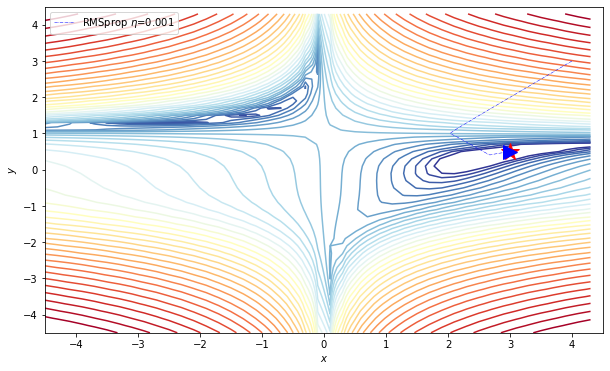

In [8]:
plt.close()

N1=10**4
lr_l=10**-3
lr_s=10**-6
grad = grad_beales_function

init1 = np.array([4, 3])
fig1, ax1=contour_beales_function()
run_and_plot(ax1, grad, init1, {'$\eta$': lr_l}, 'b-.', N1, rms_prop, True)
plt.legend(loc=2)
plt.show()
